<a href="https://colab.research.google.com/github/vondersam/sdgs_text_classifier/blob/master/experiments/sdgs_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
pre = drive.CreateFile({'id':'1ojX1O9ifhZdT78l5mcD-Ctx6yapF7T5o'})
pre.GetContentFile('preprocess.ipynb')

In [0]:
from preprocessing import count_mas

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
base_dir = "gdrive/My Drive/fastai-v3/sdgs/"
dataset_dir = base_dir + "lstm/"

In [0]:
from fastai.text import *

## Uploading the data

In [0]:
source_path = Path(dataset_dir + 'cleanup_labelled.csv')
df = pd.read_csv(source_path)
df.head()

,text,labels,doc_id
0,Goal 8: Decent work and economic growth,8,downloadable_pdfs/http:__www.dev.sdgfund.org_%...
1,The day after receiving the 2016 Pritzker Laur...,11,downloadable_pdfs/http:__www.dev.sdgfund.org_a...
2,"For Paloma Duran, SDG Fund director, this proj...",16,downloadable_pdfs/http:__www.dev.sdgfund.org_b...
3,"Rangita de Silva, Associate Dean of the Univer...",5,downloadable_pdfs/http:__www.dev.sdgfund.org_b...
4,"The SDG Fund, an interagency mechanism establi...",16,downloadable_pdfs/http:__www.dev.sdgfund.org_b...


We first create a general language model with the unlabelled data, which we will later fit into the WikiText 103 language model, so that it has more information about SDGs.

In [0]:
#data_lm = TextLMDataBunch.from_csv(dataset_dir, 'cleanup_unlabelled.csv')

In [0]:
#data_lm.show_batch()
#data_lm.save('data_lm_export.pkl')
path = Path(dataset_dir)
data_lm = load_data(path, 'data_lm_export.pkl')

# Training the general language model

We train on the first layer of the language model with all the data and a pretrained language model from the WikiText 103. This is included in the architecture of AWD_LSTM.

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


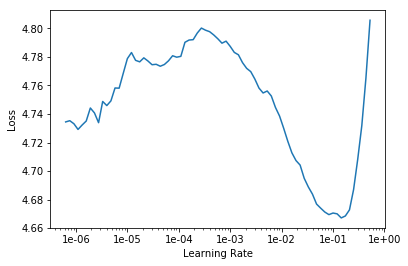

In [0]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [0]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.683069,3.525900,0.373216,53:59


In [0]:
#learn.save('fit_head')

In [7]:
learn.load('fit_head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (198642 items)
x: LMTextList
xxbos themes of the xxmaj commission where science has been effectively employed to support the,xxbos xxmaj promote and support efforts and initiatives to secure equitable access to land tenure and clarify resource rights and responsibilities , through land and tenure reform processes that respect the rule of law and are enshrined in national law , and provide access to credit for all , especially women , and that enable economic and social empowerment and poverty eradication as well as efficient and ecologically sound utilization of land and that enable women producers to become decision makers and owners in the sector , including the right to inherit land ;,xxbos xxmaj the paper is structured as follows : xxmaj section 2 presents the methodology used xxmaj section 3 describes our overall findings – an analysis of the use of targets and the degree of additional stretch that the sdgs would require xxma

In [9]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.377476,3.319256,0.397248,30:46
1,3.279190,3.227974,0.410936,31:02
2,3.206759,3.170761,0.419910,31:04
3,3.134039,3.119085,0.427909,31:03


Buffered data was truncated after reaching the output size limit.

In [0]:
learn.save_encoder('fine_tuned_encoder')

In [0]:
learn.load_encoder('fine_tuned_encoder')

In [20]:
learn.predict("African countries like", n_words=20)

'African countries like Benin and Burkina Faso face particularly serious obstacles to economic development , which require , among others'

# Training the classifier

Then we load the language model for the classifier

In [0]:
data_clas = TextClasDataBunch.from_csv(dataset_dir, 'cleanup_labelled.csv', vocab=data_lm.train_ds.vocab, bs=32, text_cols='text', label_cols="labels", label_delim="|")

In [0]:
#data_clas.save('data_clas_export.pkl')

In [0]:
#data_clas = load_data(path, 'data_clas_export.pkl', bs=16)

In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)

F1macro = partial(MultiLabelFbeta, average="macro")
F1micro = partial(MultiLabelFbeta, average="micro")
F1weighted = partial(MultiLabelFbeta, average="weighted")

learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[acc_02, f_score], callback_fns=[F1macro, F1micro, F1weighted])
learn.load_encoder('ft_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


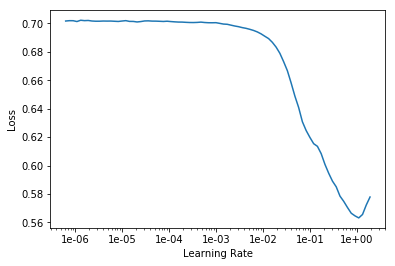

In [51]:
learn.lr_find()
learn.recorder.plot()

In [52]:
learn.fit_one_cycle(1, 3e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,macro_fbeta,micro_fbeta,weighted_fbeta,time
0,0.281346,0.248257,0.912871,0.238434,0.159213,0.163926,0.164260,00:13


In [0]:
learn.save('first')

In [55]:
learn.load('first')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (4145 items)
x: TextList
xxbos xxmaj links to health across the sdgs relating to poverty , inequality , hunger and food insecurity , xxmaj health is implicit in almost all of the other 16 xxmaj goals , not employment and peace ( see xxmaj table 2 ) . just in xxup sdg 3 . xxmaj progress on many of the xxmaj goals will affect xxmaj the range of xxup sdg targets should incentivise the health and the achievement of the xxmaj goal can be used to development of intersectoral approaches that may help incentivise progress on migrant health , in some of the ways improve migrant health , alongside the health of other detailed below . xxmaj improving the health of migrants and all vulnerable groups . xxmaj different groups of migrants have vulnerable people will be dependent on equity , as countries specific vulnerabilities and needs according to the sector work towards achieving all sdgs , particularly those in which they work or live . xxmaj 

In [56]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,macro_fbeta,micro_fbeta,weighted_fbeta,time
0,0.231646,0.212196,0.910602,0.434260,0.229493,0.251029,0.243056,00:18


In [0]:
learn.save('second')

In [0]:
lear.load('second')

In [59]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,macro_fbeta,micro_fbeta,weighted_fbeta,time
0,0.189830,0.172758,0.927903,0.558958,0.417611,0.439797,0.433209,00:29


In [0]:
learn.save('third')

In [67]:
learn.load('third')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (4145 items)
x: TextList
xxbos xxmaj links to health across the sdgs relating to poverty , inequality , hunger and food insecurity , xxmaj health is implicit in almost all of the other 16 xxmaj goals , not employment and peace ( see xxmaj table 2 ) . just in xxup sdg 3 . xxmaj progress on many of the xxmaj goals will affect xxmaj the range of xxup sdg targets should incentivise the health and the achievement of the xxmaj goal can be used to development of intersectoral approaches that may help incentivise progress on migrant health , in some of the ways improve migrant health , alongside the health of other detailed below . xxmaj improving the health of migrants and all vulnerable groups . xxmaj different groups of migrants have vulnerable people will be dependent on equity , as countries specific vulnerabilities and needs according to the sector work towards achieving all sdgs , particularly those in which they work or live . xxmaj 

In [68]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,macro_fbeta,micro_fbeta,weighted_fbeta,time
0,0.168881,0.172019,0.930626,0.548266,0.511090,0.530549,0.525620,00:31
1,0.166106,0.165505,0.932271,0.584525,0.533323,0.553059,0.548699,00:32
2,0.148114,0.146148,0.937603,0.643281,0.598660,0.616260,0.613405,00:38
3,0.137337,0.132870,0.941063,0.687717,0.653475,0.667635,0.665894,00:39
4,0.121145,0.121541,0.950309,0.722177,0.704250,0.714569,0.713650,00:32
5,0.107739,0.113774,0.953656,0.744270,0.739550,0.749346,0.748778,00:39
6,0.101359,0.112079,0.951841,0.748042,0.755568,0.764502,0.763954,00:37
7,0.093919,0.109958,0.953202,0.750796,0.769207,0.778629,0.778015,00:31
8,0.090905,0.107505,0.952805,0.757865,0.777197,0.786255,0.785658,00:35
9,0.088733,0.106956,0.956095,0.756621,0.782511,0.791358,0.790888,00:32


In [0]:
learn.save('fourth')

In [66]:
learn.load('fourth')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (4145 items)
x: TextList
xxbos xxmaj links to health across the sdgs relating to poverty , inequality , hunger and food insecurity , xxmaj health is implicit in almost all of the other 16 xxmaj goals , not employment and peace ( see xxmaj table 2 ) . just in xxup sdg 3 . xxmaj progress on many of the xxmaj goals will affect xxmaj the range of xxup sdg targets should incentivise the health and the achievement of the xxmaj goal can be used to development of intersectoral approaches that may help incentivise progress on migrant health , in some of the ways improve migrant health , alongside the health of other detailed below . xxmaj improving the health of migrants and all vulnerable groups . xxmaj different groups of migrants have vulnerable people will be dependent on equity , as countries specific vulnerabilities and needs according to the sector work towards achieving all sdgs , particularly those in which they work or live . xxmaj 

In [70]:
learn.show_results(rows=500)

text,target,prediction
"xxbos xxmaj priority xxmaj theme 4 : xxmaj quality of xxmaj growth and xxmaj employment 3.4.1 xxmaj rationale for the xxmaj goal and xxmaj sub - xxmaj goals xxmaj growth and employment are intertwined : economic growth creates employment and employment fuels economic growth . xxmaj both are preconditions to reducing poverty , but it is their quality that will actually matter to vulnerable segments of society . xxmaj only",4;8,4;8
"xxbos xxmaj china , xxmaj korea and xxmaj singapore defined goals with underlying targets and indicators . xxmaj china aims at “ building a water - saving society ” ( xxmaj national xxmaj development and xxmaj reform xxmaj commission of xxmaj china , 2011 ) , xxmaj korea plans to increase the efficiency and equity of water management through an improved water pricing system and xxmaj singapore aims for self",9,
"xxbos resilience and sustainability and marine ecosystems as per xxup sdg 14 will depend more on efforts at regional and national levels , backed up with regular monitoring , stock - take and identification of necessary policy measures at the global and multilateral level . xxmaj part xxup ii also examines challenges and opportunities for harvest and trade in sustainable fisheries from wild catch and aquaculture , private standards affecting",14,14
"xxbos xxmaj nature xxmaj based xxmaj solutions , xxmaj ecosystem based approaches and xxmaj urban xxmaj ecosystem xxmaj management : xxmaj challenges and approaches with reference to xxup sdg xxmaj goal 11 xxmaj urban environmental management is a challenge faced by many cities in xxmaj asia . xxmaj at the same time , developing cities in xxmaj asia confront a number of other issues as well . xxmaj while on",11,11
"xxbos who face inequality and discrimination , are disproportionately affected by the impacts of climate change and other environmental issues , such as diverse types of extreme weather events . xxmaj referring to and building on the xxmaj paris xxmaj agreement under the xxmaj united xxmaj nations xxmaj framework xxmaj convention on xxmaj climate xxmaj change , the xxmaj commission reiterated that countries should , when taking action to address",16,16;5
xxbos xxmaj enhancing the xxmaj contribution of xxmaj export xxmaj processing xxmaj zones to the xxmaj sustainable xxmaj development xxmaj goals 2.2.3 xxmaj changing xxup wto rules applying to epzs xxmaj the competitive landscape for epzs is changing in part due to an adjustment in the xxup wto ’s xxmaj agreement on xxmaj subsidies and xxmaj countervailing xxmaj measures ( xxup scm ) regime that seeks to phase out the,2,
"xxbos xxmaj like the ipoa , xxup sdg 17.12 emphasizes the realization of timely implementation of duty - free and quota - free market access on a lasting basis for all ldcs , consistent with the xxmaj world xxmaj trade xxmaj organization decisions , including by ensuring that preferential rules of origin applicable to imports from ldcs are transparent and simple and contribute to facilitating market access . xxmaj the",10;17;8,10;8
"xxbos xxmaj therefore , there is a need to also consider policies that can support better conditions in the informal economy in the short term . xxmaj low - skilled rural to urban migrants seeking better job opportunities in the city in fast urbanising developing countries often end up working in precarious occupations in the informal economy . xxmaj goal 11 : xxmaj make cities and human settlements inclusive ,",1;11;3;4;5,1;11;3;4
"xxbos xxmaj an analysis of 100 epzs and a xxmaj framework for xxmaj sustainable xxmaj economic xxmaj zones 1 . xxmaj introduction xxmaj historically , the relationship between industrialization , international trade and sustainable development has been xxunk xxmaj launched by the xxmaj united xxmaj nations in 2015 , the xxmaj sustainable xxmaj development xxmaj goals ( sdgs ) demonstrate the commitment of member states to make that relationship entirely",12;8;9,12;8;9
"xxbos xxmaj gender 